In [1]:
!pip install -U "langchain[groq]"


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# pip install -qU "langchain[anthropic]" to call the model

from langgraph.prebuilt import create_react_agent
from dotenv import load_dotenv
load_dotenv()

def assist_with_dog_care(suggest: str) -> str:
    """Guide the user with Dog care
    Args:
        suggest(str): the topic of guidance, it can be any of
                                                * Dog adoption suggestion
                                                * Dog care
                                                * Dog maintenance
                                                * Dog grooming
                                                * Dog health
                                                * Dog anxiety
    """
    
    if suggest=="Dog anxiety":
        return f"Don't worry! Your Dog will be fine"
    return f"I am glad to help you with {suggest}"
        

    

persona = f"""
You are an Dog care Guide, capable of assisting in the following domains:
* Dog adoption suggestion
* Dog care
* Dog maintenance
* Dog grooming
* Dog health
* Dog anxiety

"""


agent = create_react_agent(
    model="groq:llama-3.1-8b-instant",
    tools=[assist_with_dog_care],
    prompt="You are a helpful assistant"
)

from IPython.display import display_markdown
def my_petcare(message):
    
    out = agent.invoke(
    {"messages": [{"role": "user", "content": message}]}
    )
    display_markdown(out['messages'][-1].content, raw= True)

In [3]:
my_petcare("My dog's hair grew long")

<function=assist_with_dog_care>{"suggest": "Dog grooming"}

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
load_dotenv()
llm = init_chat_model("groq:llama-3.1-8b-instant")

In [6]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [7]:
graph_builder.add_edge(START, "chatbot")

In [8]:
graph_builder.add_edge("chatbot", END)

In [9]:
graph = graph_builder.compile()

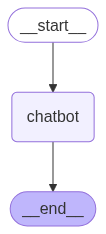

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: How can I assist you today?
Goodbye!


In [12]:
pip install -U langchain-tavily

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import os

In [14]:
from dotenv import load_dotenv

In [15]:
load_dotenv()

True

In [16]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'content': '*   **Stateful Graph:** LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges, allowing you to dynamically determine the next node to execute based on the current state of the graph. Image 10: Introduction to AI Agent with LangChain and LangGraph: A Beginner’s Guide Image 18: How to build LLM Agent with LangGraph\u200a—\u200aStateGraph and Reducer Image 20: Simplest Graphs using LangGraph Framework Image 24: Building a ReAct Agent with Langgraph: A Step-by-Step Guide Image 28: Building an Ag

In [17]:
from IPython.display import display_markdown
def get_search_result(query):
    raw_response = tool.invoke(query)
    for i in raw_response["results"]:
        display_markdown(i["content"], raw= True)
    #print(raw_response)
    

In [18]:

res = get_search_result("iran War")

An armed conflict between Iran and Israel began when Israel launched surprise attacks on key military and nuclear facilities in Iran on 13 June 2025, in the

The recent war between Israel and Iran, followed by direct U.S. involvement, marked a major escalation in the region and derailed high-level

In [19]:
import os
from langchain.chat_models import init_chat_model

os.environ["GROQ_API_KEY"] = "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"

llm = init_chat_model("groq:llama-3.1-8b-instant")

In [20]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [22]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

ValueError: Node `tools` already present.

In [23]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

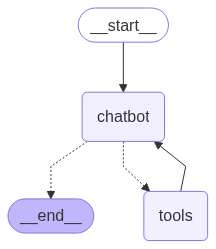

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "ipl 2025 winner", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://sports.yahoo.com/article/royal-challengers-bengaluru-win-maiden-183156466.html", "title": "Royal Challengers Bengaluru Win Maiden IPL Trophy - Yahoo Sports", "content": "Royal Challengers Bengaluru Win Maiden IPL Trophy - Yahoo Sports בשימוש שלך באתר ובאפליקציות שלנו אנחנו משתמשים בקובצי Cookie כדי: אם תלחץ על 'קבל הכול', אנחנו והשותפים שלנו, כולל 241, המהווים חלק מהמסגרת לשקיפות ולהסכמה ב-IAB, נאחסן מידע במכשיר ו/או תהיה לנו גישה אליו במכשיר (במילים אחרות, נשתמש בקובצי Cookie). אם אינך רוצה שאנחנו והשותפים שלנו נשתמש בקובצי Cookie ובנתונים האישיים שלך למטרות אלו, לחץ על ‚דחה הכול‘. כדי לקבל מידע נוסף על השימוש שאנחנו עושים בנתונים אישיים שלך, אפשר לעיין במדיניות הפרטיות ובמדיניות בנושא קוקיות שלנו. This one is for the fans of RCB who never left our side in the worst of times. Fantasy Sports Women's Sports College Sports Yahoo Sports AM Image 17: D

In [26]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [27]:
graph = graph_builder.compile(checkpointer=memory)

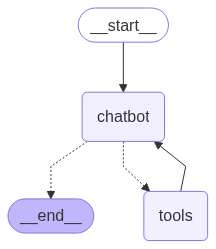

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
config = {"configurable": {"thread_id": "1"}}

In [30]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Nice to meet you, Will. Is there something I can help you with or would you like to chat?


In [31]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I remember your name is Will.


In [32]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I'm a large language model, I don't have personal memories or the ability to recall individual users. Each time you interact with me, it's a new conversation and I don't retain any information from previous conversations.


In [33]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='cd9ee2cb-10de-4971-b540-8cf1f548a334'), AIMessage(content='Nice to meet you, Will. Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1271, 'total_tokens': 1294, 'completion_time': 0.030666667, 'prompt_time': 0.082889914, 'queue_time': 0.222238398, 'total_time': 0.113556581}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'stop', 'logprobs': None}, id='run--9e7bed98-4730-4dbc-a447-64d2ad51356a-0', usage_metadata={'input_tokens': 1271, 'output_tokens': 23, 'total_tokens': 1294}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='6348787a-feb0-4f6f-afe8-900d7e74dc51'), AIMessage(content='I remember your name is Will.', additional_kwargs={}, response_metadat

In [38]:
print(snapshot)



StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='cd9ee2cb-10de-4971-b540-8cf1f548a334'), AIMessage(content='Nice to meet you, Will. Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1271, 'total_tokens': 1294, 'completion_time': 0.030666667, 'prompt_time': 0.082889914, 'queue_time': 0.222238398, 'total_time': 0.113556581}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'stop', 'logprobs': None}, id='run--9e7bed98-4730-4dbc-a447-64d2ad51356a-0', usage_metadata={'input_tokens': 1271, 'output_tokens': 23, 'total_tokens': 1294}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='6348787a-feb0-4f6f-afe8-900d7e74dc51'), AIMessage(content='I remember your name is Will.', additional_kwargs={}, response_metadat

In [39]:
for msg in snapshot.values['messages']:
    print(f"{type(msg).__name__}: {msg.content}")


HumanMessage: Hi there! My name is Will.
AIMessage: Nice to meet you, Will. Is there something I can help you with or would you like to chat?
HumanMessage: Remember my name?
AIMessage: I remember your name is Will.


In [41]:
print(snapshot.values)


{'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='cd9ee2cb-10de-4971-b540-8cf1f548a334'), AIMessage(content='Nice to meet you, Will. Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1271, 'total_tokens': 1294, 'completion_time': 0.030666667, 'prompt_time': 0.082889914, 'queue_time': 0.222238398, 'total_time': 0.113556581}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'stop', 'logprobs': None}, id='run--9e7bed98-4730-4dbc-a447-64d2ad51356a-0', usage_metadata={'input_tokens': 1271, 'output_tokens': 23, 'total_tokens': 1294}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='6348787a-feb0-4f6f-afe8-900d7e74dc51'), AIMessage(content='I remember your name is Will.', additional_kwargs={}, response_metadata={'token_usage': {'c

In [42]:
last_message = snapshot.values['messages'][-1]
print(last_message.content)


I remember your name is Will.


In [36]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()